# Build a CALSPEC list of observable target from getCalspec package and generate sky trajectories and plot

- Author Sylvie Dagoret-Campagne
- Creation : August 22th 2023
- Update : August 23th 2023 : all bug corrected
- Update : August 24th 2023 : add UTC time to plots
- Update : August 29th 2023 : preselection fo target activated by a FLAG
- Update : August 29th 2023 : Correct a big bug on Longitide angle and ra selection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style, quantity_support
plt.style.use(astropy_mpl_style)
quantity_support()
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from matplotlib.dates import (AutoDateLocator, YearLocator, MonthLocator,
                              DayLocator, WeekdayLocator, HourLocator,
                              MinuteLocator, SecondLocator, MicrosecondLocator,
                              RRuleLocator, rrulewrapper, MONTHLY,
                              MO, TU, WE, TH, FR, SA, SU, DateFormatter,
                              AutoDateFormatter, ConciseDateFormatter)

%matplotlib inline
import pandas as pd

In [2]:
import astropy.units as u
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.coordinates import Angle
from astropy.time import Time, TimezoneInfo,TimeDelta
from astropy.coordinates import Longitude,Latitude

In [3]:
import datetime as dt
from datetime import datetime
import timezonefinder, pytz
from calendar import monthrange
import calendar

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
from astroquery.simbad import Simbad

In [6]:
# to view the list of VOTABLE
# Simbad.list_votable_fields()

In [7]:
Simbad.add_votable_fields('sptype')
Simbad.add_votable_fields('flux(U)') # add the Vega unit Magnitude 
Simbad.add_votable_fields('flux(B)') # add the Vega unit Magnitude 
Simbad.add_votable_fields('flux(V)') # add the Vega unit Magnitude 
Simbad.add_votable_fields('flux(R)') # add the Vega unit Magnitude 
Simbad.add_votable_fields('flux(I)') # add the Vega unit Magnitude 
#Simbad.add_votable_fields('flux_unit(V)')
#Simbad.add_votable_fields('flux_unit(I)')
#Simbad.add_votable_fields('flux_system(V)')
#Simbad.add_votable_fields('flux_system(I)')
#Simbad.add_votable_fields('ubv')  # Johnson UBV system

In [8]:
plt.rcParams["axes.labelsize"]="large"
plt.rcParams["axes.linewidth"]=2.0
plt.rcParams["xtick.major.size"]=8
plt.rcParams["ytick.major.size"]=8
plt.rcParams["ytick.minor.size"]=5
plt.rcParams["xtick.labelsize"]="large"
plt.rcParams["ytick.labelsize"]="large"

plt.rcParams["figure.figsize"]=(12,8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
#plt.rcParams['axes.facecolor'] = 'blue'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
plt.rcParams['lines.markersize'] = 5  # markersize, in points
plt.rcParams['grid.alpha'] = 0.75 # transparency, between 0.0 and 1.0
plt.rcParams['grid.linestyle'] = '-' # simple line
plt.rcParams['grid.linewidth'] = 0.4 # in points
plt.rcParams['font.size'] = 13

In [9]:
def CalculateBounds(theta,thetamin,thetamax):
    """
    Handle the boundaries of angles
    
    parameters:
        theta : the input angle in degree to test
        thetamin: lower bound angle
        thetamax: upper bound angle
    """
    
    theta_min_angle = Longitude(thetamin,unit=u.degree)
    theta_max_angle = Longitude(thetamax,unit=u.degree)
    theta_angle = Longitude(theta,unit=u.degree)
    
    
    #print("longitude angles",theta_angle,theta_min_angle,theta_max_angle)
    
    
    wrap = 0
    
    if theta_min_angle.degree < theta_max_angle.degree:
        wrap = 360 * u.deg
    else:
        wrap = 180 * u.deg
        
    theta_min_angle.wrap_angle = wrap
    theta_max_angle.wrap_angle = wrap
    theta_angle.wrap_angle = wrap
       
    #print("wrap",wrap,"theta=",theta_angle,"theta_min=",theta_min_angle,"theta_max",theta_max_angle)
    return theta_angle.is_within_bounds(theta_min_angle,theta_max_angle)
    

## CALSPEC

Use the package getCalspec to work on CALSPEC object

https://github.com/LSSTDESC/getCalspec/blob/main/getCalspec/getCalspec.py

https://github.com/LSSTDESC/getCalspec/tree/main/getCalspec

In [10]:
# to get all Calspec data in one time in cache, write¶
from getCalspec.rebuild import rebuild_cache
# rebuild_cache()

In [11]:
# When the STSC webpage is updated, it might be necessary to rebuild the calspec_data/calspec.csv table and the cache:¶
from getCalspec.rebuild import rebuild_tables, rebuild_cache
#rebuild_tables()
#rebuild_cache()

### Retrieve all calspec

Try directly reading the table from getCalspec package. If not possible, read directly this table from the table stored in filename = "../../calspec_data/calspec.csv"

In [12]:
from getCalspec.getCalspec import getCalspecDataFrame

In [13]:
flag_getscalspec = False
try:
    df = getCalspecDataFrame()
    flag_getscalspec = True
except:
    filename = "../../calspec_data/calspec.csv"
    df = pd.read_csv(filename,index_col=0)  
finally:
    print(f"getCalspec : {flag_getscalspec}")
    print(df.head())   

getCalspec : True
   Unnamed: 0 Star_name   Sp_T      V    B_V     Name     Model          STIS  \
0           0   109 VIR  A0III   3.73  -0.01   109vir  _mod_003     _stis_003   
1           1    10 LAC    O9V   4.88  -0.21    10lac  _mod_005     _stis_007   
2           2  16 CYG B    G3V   6.20   0.66   16cygb  _mod_003     _stis_003   
3           3    18 SCO    G2V   5.50   0.65    18sco  _mod_004     _stis_004   
4           4   1732526    A4V  12.53   0.12  1732526  _mod_005  _stisnic_007   

  Var_(%)            RA          Decl    Vr      PM    PM.1  \
0     NaN  14 46 14.925  +01 53 34.38  -6.1 -114.03  -22.13   
1   <0.23  22 39 15.679  +39 03 00.97 -10.0   -0.32   -5.46   
2   <0.21  19 41 51.973  +50 31 03.09 -27.7 -134.79 -162.49   
3     NaN  16 15 37.270  -08 22 09.98  11.9  232.16 -495.37   
4    1.40  17 32 52.630  +71 04 43.12   NaN    0.22   -2.71   

               Simbad_Name  Alt_Simbad_Name  Astroquery_Name Alt_Star_name  \
0                 HD130109            

In [14]:
df

,Unnamed: 0,Star_name,Sp_T,V,B_V,Name,Model,STIS,Var_(%),RA,Decl,Vr,PM,PM.1,Simbad_Name,Alt_Simbad_Name,Astroquery_Name,Alt_Star_name,HD_name
0,0,109 VIR,A0III,3.73,-0.01,109vir,_mod_003,_stis_003,NaN,14 46 14.925,+01 53 34.38,-6.1,-114.03,-22.13,HD130109,NaN,* 109 VIR,NaN,HD130109
1,1,10 LAC,O9V,4.88,-0.21,10lac,_mod_005,_stis_007,<0.23,22 39 15.679,+39 03 00.97,-10.0,-0.32,-5.46,NaN,NaN,* 10 LAC,NaN,HD214680
2,2,16 CYG B,G3V,6.20,0.66,16cygb,_mod_003,_stis_003,<0.21,19 41 51.973,+50 31 03.09,-27.7,-134.79,-162.49,HD186427,NaN,* 16 CYG B,NaN,HD186427
3,3,18 SCO,G2V,5.50,0.65,18sco,_mod_004,_stis_004,NaN,16 15 37.270,-08 22 09.98,11.9,232.16,-495.37,HD146233,NaN,* 18 SCO,NaN,HD146233
4,4,1732526,A4V,12.53,0.12,1732526,_mod_005,_stisnic_007,1.40,17 32 52.630,+71 04 43.12,NaN,0.22,-2.71,2MASS J17325264+7104431,TYC 4424-1286-1,TYC 4424-1286-1,NaN,NaN
5,5,1740346,A6V,12.48,0.20,1740346,NaN,_stisnic_005,NaN,17 40 34.679,+65 27 14.77,NaN,-5.72,-3.44,2MASS J17403468+6527148,TYC 4207-219-1,TYC 4207-219-1,NaN,NaN
6,6,1743045,A8III,13.52,0.28,1743045,_mod_005,_stisnic_007,<1.32,17 43 04.486,+66 55 01.66,NaN,1.10,-2.79,2MASS J17430448+6655015,NaN,2MASS J17430448+6655015,NaN,NaN
7,7,1757132,A3V,12.01,-0.10,1757132,_mod_005,_stiswfc_004,<0.37,17 57 13.233,+67 03 40.77,NaN,0.41,-14.03,2MASS J17571324+6703409,TYC 4212-455-1,TYC 4212-455-1,NaN,NaN
8,8,1802271,A2V,11.53,0.02,1802271,_mod_005,_stiswfcnic_004,<0.82,18 02 27.163,+60 43 35.54,NaN,5.40,2.17,2MASS J18022716+6043356,TYC 4201-1542-12,BPS BS 17447-0067,NaN,NaN
9,9,1805292,A4V,12.28,0.14,1805292,_mod_004,_stisnic_006,<0.49,18 05 29.275,+64 27 52.13,NaN,-1.64,10.06,2MASS J18052927+6427520,TYC 4209-1396-1,TYC 4209-1396-1,NaN,NaN


## Calculate the Visibility of the star

### Observation date

In [15]:
NYEAR=2023
NMONTH=9
NDAY=12

### Selection of object

    HD185975 20:28:18 -87:28:19.9 type G3V, V=8.10

    HD14943 02:22:54 -51:05:31.7 type A5V, V=5.91

    HD38666 05:46:00 -32:18:23.2  type O9.5V, V=5.2

    HD60753 07:33:27 -50:35:03.3  type B3IV, V=6.7 

    HD146233 16:15:37 -08:22:10.0  type G2V, V=5.5

In [16]:
FLAG_PRESELECTION_TARGET = False
preselected_target_names = np.array(["HD185975","HD14943","HD38666","HD60753","HD146233"])

### Examples from https://docs.astropy.org/en/stable/generated/examples/coordinates/plot_obs-planning.html

In [17]:
m33 = SkyCoord.from_name('M33')

In [18]:
bear_mountain = EarthLocation(lat=41.3*u.deg, lon=-74*u.deg, height=390*u.m)
utcoffset = -4*u.hour  # Eastern Daylight Time
time = Time('2023-9-12 23:00:00') - utcoffset

In [19]:
m33altaz = m33.transform_to(AltAz(obstime=time,location=bear_mountain))
print(f"M33's Altitude = {m33altaz.alt:.2}")

M33's Altitude = 4.1e+01 deg


## My Location

In summer the UTC offset at my location is + 2 H

In [20]:
mylat = 48.8534
mylong = 2.3488

In [21]:
paris = EarthLocation(lat=mylat*u.deg, lon=mylong*u.deg, height=0*u.m)
utcoffset = 2*u.hour  # CET
time = Time('2023-9-12 23:00:00') - utcoffset

In [22]:
tf = timezonefinder.TimezoneFinder()
mytimezone_str = tf.certain_timezone_at(lat=mylat, lng=mylong)

In [23]:
mytimezone_str

'Europe/Paris'

In [24]:
if mytimezone_str is None:
    print("Could not determine my time zone")
else:
    # Display the current time in that time zone
    
    
    timezone = pytz.timezone(mytimezone_str)
    timezone0 = pytz.timezone('UTC')
    
    dt = datetime.utcnow()
    timeParis_now = datetime.now(timezone)
    
    print("The UTC Time now %s" % dt)
    print("The actual time in %s is %s" % (mytimezone_str, dt + timezone.utcoffset(dt)))

The UTC Time now 2023-08-29 12:56:00.326124
The actual time in Europe/Paris is 2023-08-29 14:56:00.326124


### For LSST

### Observation location

In [25]:
LSSTNAME='Cerro Pachon'
lsst_location=EarthLocation.of_site(LSSTNAME)
longitude=lsst_location.lon
latitude=lsst_location.lat
altitude=lsst_location.height

In [26]:
cerro_pachon = EarthLocation(lat=latitude.degree*u.deg, lon=longitude.degree*u.deg, height=altitude)

### Determination of UTC offset from TimeZone in Chile

In [27]:
tf = timezonefinder.TimezoneFinder()
timezone_str = tf.certain_timezone_at(lat=latitude.degree, lng=longitude.degree)

In [28]:
print(f"Time zone at Rubin LSST Observatory: {timezone_str}")

Time zone at Rubin LSST Observatory: America/Santiago


In [29]:
if timezone_str is None:
    print("Could not determine the time zone")
else:
    # Display the current time in that time zone
    
    #tz = pytz.timezone('Europe/Berlin')
    #berlin_now = datetime.now(tz)
    
    timezone = pytz.timezone(timezone_str)
    timezone0 = pytz.timezone('UTC')
    
    dt = datetime.utcnow()
    timeChile_now = datetime.now(timezone)
    
    print("The UTC Time now %s" % dt)
    print("The actual time in %s is %s" % (timezone_str, dt + timezone.utcoffset(dt)))

The UTC Time now 2023-08-29 12:56:00.631174
The actual time in America/Santiago is 2023-08-29 08:56:00.631174


In [30]:
utcoffset=timezone.utcoffset(dt).total_seconds()/60./60.
print("The UTC offset in Chile is ",utcoffset," hours")

The UTC offset in Chile is  -4.0  hours


In [31]:
tz_utc_minus_xx_hours = TimezoneInfo(utc_offset=int(utcoffset)*u.hour)
tz_utc_minus_xx_hours

In [32]:
timezone.utcoffset

<bound method DstTzInfo.utcoffset of <DstTzInfo 'America/Santiago' LMT-1 day, 19:17:00 STD>>

### Night of observation

In [33]:
night_obs = datetime(NYEAR, NMONTH, NDAY, 0, 0)
night_obs_midnight= datetime(NYEAR, NMONTH, NDAY, 23, 59,59,tzinfo = tz_utc_minus_xx_hours)

In [34]:
night_obs_str=night_obs.strftime("%Y-%m-%d %H:%M:%S")
print(f"Night of Observation : {night_obs_str}")

Night of Observation : 2023-09-12 00:00:00


In [35]:
night_obs_midnight_str=night_obs_midnight.strftime("%Y-%m-%d %H:%M:%S")
night_obs_midnight_str
print(f"Midnight of Night of Observation : {night_obs_midnight_str}")

Midnight of Night of Observation : 2023-09-12 23:59:59


### Compute UTC and Sideral Time at local midnight

In [36]:
tz_utc = TimezoneInfo() 
print("Local time in Santiago in summer (GMT-4) in summer : ",night_obs_midnight)
print("Time in UTC                               : ",night_obs_midnight.astimezone(tz_utc))

Local time in Santiago in summer (GMT-4) in summer :  2023-09-12 23:59:59-04:00
Time in UTC                               :  2023-09-13 03:59:59+00:00


### Sideral time at LSST site midnight

In [37]:
t_lsst = Time(night_obs_midnight.astimezone(tz_utc), scale='utc',location=lsst_location)
t_sidereal_lsst = t_lsst.sidereal_time('apparent')  
print("Sideral Time at LSST midnight:",t_sidereal_lsst)

Sideral Time at LSST midnight: 22h44m36.72873971s


In [38]:
print("Sideral Time angle at LSST midnight:",Angle(t_sidereal_lsst).to(u.degree))

Sideral Time angle at LSST midnight: 341d09m10.93109565s


In [39]:
print("Sideral Time angle at LSST midnight:",Angle(t_sidereal_lsst).degree)

Sideral Time angle at LSST midnight: 341.153036415458


In [40]:
# To check
t_lsst_2 = Time('2023-09-13 03:59:59', scale='utc',location=('-70.73668333d', '-30.24074167d'))
t_lsst_2.sidereal_time('apparent') 

<Longitude 22.74353576 hourangle>

## Filter Obervable targets according RA and magnitude and culmination angle

- Select the target which Right-Asccention is +/- 6 hours from the sideral time

- The culmination Hour angle at the meridian must not be less than -6H to + 6H

### Criteria on Margin Angle

In [41]:
MarginAngle = Angle(6.0,u.hour)
MarginAngle

<Angle 6. hourangle>

In [42]:
#calculate tdege range of RA target to be visible within the MarginAngle
#ra_min = (t_sidereal_lsst - MarginAngle).degree
#ra_max = (t_sidereal_lsst + MarginAngle).degree
ra_min = Longitude((t_sidereal_lsst - MarginAngle).degree,unit=u.deg)
ra_max = Longitude((t_sidereal_lsst + MarginAngle).degree,unit=u.deg)

In [43]:
ra_min

<Longitude 251.15303642 deg>

In [44]:
ra_max

<Longitude 71.15303642 deg>

In [45]:
ra_max

<Longitude 71.15303642 deg>

In [46]:
#ra_min_angle = Angle(ra_min,u.degree)
#ra_max_angle = Angle(ra_max,u.degree)
ra_min_angle = Longitude(ra_min,u.degree)
ra_max_angle = Longitude(ra_max,u.degree)
#ra_min_angle.wrap_angle = 180 * u.deg
#ra_max_angle.wrap_angle = 180 * u.deg

In [47]:
ra_min_angle.degree

251.15303641545802

In [48]:
ra_max_angle.degree

71.15303641545796

### Criteria on culmination angle

In [49]:
culmin_angle_min = 40

### Criteria on magnitude in V

In [50]:
magLim = 12.

In [51]:
latitude

<Latitude -30.24074167 deg>

In [52]:
all_flag_select = []

# numeric collections
all_ra_angles_deg = []
all_dec_angles_deg = []
all_altmax_angle_deg = []
all_zenithmin_angle_deg = []
all_magV = []

# loop on rach entries in the df table to calculate angles

for index, row in df.iterrows(): 
    target_name = row["Star_name"]
    hd_name = row["HD_name"]
    
    # compute numeric values for ra-dec
    #ra_angle = Angle(row['RA'],unit = u.hour) # the RA angle is a string in Sexagesimal hours 
    ra_angle = Longitude(row['RA'],unit = u.hour) # the RA angle is a string in Sexagesimal hours
    #ra_angle.wrap_angle = 180 * u.deg
    
    
    dec_angle = Angle(row["Decl"],unit = u.deg) # the dec angle is a string in degrees 
    
    # compute culmination angle
    if latitude.deg >= 0:
        if dec_angle.deg >= latitude.deg:
            zenith_angle =   dec_angle - latitude
        else:
            zenith_angle = latitude - dec_angle
    else:
        if dec_angle.deg < latitude.deg :
            zenith_angle =   latitude - dec_angle 
        else:
            zenith_angle =   dec_angle - latitude 
        
        
    
    
    culmination_angle = Angle(90.0, unit = u.deg) - zenith_angle
    
    if (index !=12) and (index !=13) and (index!= 95):
        magV = float(row["V"])
    else:
        if index == 12:
            magV =12.47
        elif index==13:
            magV = 13.80
        elif index == 95:
            magV = 17.01
            
             
    all_ra_angles_deg.append(ra_angle.degree)
    all_dec_angles_deg.append(dec_angle.degree)
    all_altmax_angle_deg.append(culmination_angle.degree) 
    all_zenithmin_angle_deg.append(zenith_angle.degree )
    all_magV.append(magV)
  
    # test on ra angle
    #flag1 = ra_angle.is_within_bounds(ra_min_angle,ra_max_angle)
    flag1 = CalculateBounds(ra_angle.degree,ra_min_angle.degree,ra_max_angle.degree)
    
    flag2 = (magV < magLim)
    flag3 = False
    
    # test on culmination angle
    if culmination_angle.degree > culmin_angle_min :
        flag3 = True
        
    
    flag = flag1 & flag2 & flag3
    
    if target_name == "HD185975":
        # keep polar star
        flag = True

    # test on preselected names
    if FLAG_PRESELECTION_TARGET:
        if target_name in preselected_target_names:
          
            if not flag:
                print(f"BE CAREFULL , a rejected target {target_name} is in Pre-Selection list, PLEASE CHECK")
            flag =True
        else:
            if flag:
                print(f"BE CAREFULL , a good target {target_name} is not in Pre-Selection list, PLEASE CHECK")
            flag = False
        
    
    if flag:
        print(f"{index}, {target_name} ({hd_name}), RA = {ra_angle.hour:.2f} , DEC = {dec_angle.degree:.2f} , RA-MIN-MAX = {ra_min_angle.deg:.1f}-{ra_max_angle.deg:.1f},zenith_angle = {zenith_angle.degree:.2f}  culmination angle = {culmination_angle.degree:.2f} , magV = {magV} , flag_select = {flag}")
   
    all_flag_select.append(flag)                

16, BD+02 3375 (nan), RA = 17.66 , DEC = 2.42 , RA-MIN-MAX = 251.2-71.2,zenith_angle = 32.66  culmination angle = 57.34 , magV = 9.93 , flag_select = True
23, BD+17 4708 (nan), RA = 22.19 , DEC = 18.09 , RA-MIN-MAX = 251.2-71.2,zenith_angle = 48.33  culmination angle = 41.67 , magV = 9.47 , flag_select = True
29, FEIGE110 (nan), RA = 23.33 , DEC = -5.17 , RA-MIN-MAX = 251.2-71.2,zenith_angle = 25.08  culmination angle = 64.92 , magV = 11.83 , flag_select = True
36, HD009051 (HD9051), RA = 1.48 , DEC = -24.34 , RA-MIN-MAX = 251.2-71.2,zenith_angle = 5.90  culmination angle = 84.10 , magV = 8.92 , flag_select = True
46, HD14943 (HD14943), RA = 2.38 , DEC = -51.09 , RA-MIN-MAX = 251.2-71.2,zenith_angle = 20.85  culmination angle = 69.15 , magV = 5.91 , flag_select = True
49, HD160617 (HD160617), RA = 17.71 , DEC = -40.32 , RA-MIN-MAX = 251.2-71.2,zenith_angle = 10.08  culmination angle = 79.92 , magV = 8.73 , flag_select = True
52, HD167060 (HD167060), RA = 18.30 , DEC = -61.71 , RA-MIN-M

## Add calculated numerical values to the pandas table

In [53]:
df["ra_deg"] = all_ra_angles_deg
df["dec_deg"] = all_dec_angles_deg 
df["alt_max"] = all_altmax_angle_deg
df["zenith_min"] = all_zenithmin_angle_deg
df["magV"] = all_magV 

### Example for debug

In [54]:
cut = df["Star_name"] == "HD205905"

In [55]:
df[cut]

,Unnamed: 0,Star_name,Sp_T,V,B_V,Name,Model,STIS,Var_(%),RA,Decl,Vr,PM,PM.1,Simbad_Name,Alt_Simbad_Name,Astroquery_Name,Alt_Star_name,HD_name,ra_deg,dec_deg,alt_max,zenith_min,magV
58,58,HD205905,G2V,6.74,0.62,hd205905,_mod_006,_stis_008,0.26,21 39 10.151,-27 18 23.67,-17.0,384.1,-83.96,NaN,NaN,HD 205905,NaN,HD205905,324.792296,-27.306575,87.065833,2.934167,6.74


## Apply selection cut

In [56]:
df["select"] = all_flag_select
cut = df["select"] == True

t=df[cut]
NTargets=len(t)

In [57]:
t

,Unnamed: 0,Star_name,Sp_T,V,B_V,Name,Model,STIS,Var_(%),RA,Decl,Vr,PM,PM.1,Simbad_Name,Alt_Simbad_Name,Astroquery_Name,Alt_Star_name,HD_name,ra_deg,dec_deg,alt_max,zenith_min,magV,select
16,16,BD+02 3375,A5,9.93,0.45,bd02d3375,_mod_003,_stis_006,NaN,17 39 45.595,+02 24 59.61,-398.0,-366.01,75.12,NaN,NaN,BD+02 3375,NaN,NaN,264.939979,2.416558,57.342700,32.657300,9.93,True
23,23,BD+17 4708,sdF8,9.47,0.44,bd_17d4708,NaN,_stisnic_007,NaN,22 11 31.375,+18 05 34.16,-291.0,506.37,60.49,NaN,NaN,BD+17 4708,NaN,NaN,332.880729,18.092822,41.666436,48.333564,9.47,True
29,29,FEIGE110,sdO,11.83,-0.30,feige110,NaN,_stisnic_008*,NaN,23 19 58.400,-05 09 56.17,NaN,-10.68,0.31,NaN,NaN,FEIGE 110,NaN,NaN,349.993333,-5.165603,64.924861,25.075139,11.83,True
36,36,HD009051,G7III,8.92,0.81,hd009051,_mod_004,_stis_007,NaN,01 28 46.503,-24 20 25.44,-72.0,53.56,-17.03,NaN,NaN,HD 9051,NaN,HD9051,22.193762,-24.340400,84.099658,5.900342,8.92,True
46,46,HD14943,A5V,5.91,0.19,hd14943,_mod_003,_stis_005,0.05,02 22 54.675,-51 05 31.66,5.0,22.33,66.38,HR 701,NaN,HD 14943,NaN,HD14943,35.727812,-51.092128,69.148614,20.851386,5.91,True
49,49,HD160617,F,8.73,0.45,hd160617,_mod_002,_stis_005,NaN,17 42 49.324,-40 19 15.51,100.0,-62.39,-393.23,NaN,NaN,HD 160617,NaN,HD160617,265.705517,-40.320975,79.919767,10.080233,8.73,True
52,52,HD167060,G3V,8.92,0.64,hd167060,_mod_004,_stis_004,<0.09,18 17 44.143,-61 42 31.62,15.2,88.52,-145.15,NaN,NaN,HD 167060,NaN,HD167060,274.433929,-61.708783,58.531958,31.468042,8.92,True
55,55,HD185975,G3V,8.10,0.68,hd185975,_mod_004,_stis_007,NaN,20 28 18.740,-87 28 19.94,-19.0,169.76,-56.99,NaN,NaN,HD 185975,NaN,HD185975,307.078083,-87.472206,32.768536,57.231464,8.10,True
56,56,HD200654,G,9.11,0.63,hd200654,_mod_004,_stis_007,NaN,21 06 34.751,-49 57 50.28,-45.0,193.94,-273.89,NaN,NaN,HD 200654,NaN,HD200654,316.644796,-49.963967,70.276775,19.723225,9.11,True
58,58,HD205905,G2V,6.74,0.62,hd205905,_mod_006,_stis_008,0.26,21 39 10.151,-27 18 23.67,-17.0,384.10,-83.96,NaN,NaN,HD 205905,NaN,HD205905,324.792296,-27.306575,87.065833,2.934167,6.74,True


### Must reindex the table

In [58]:
t = t.reset_index(drop=True)

In [59]:
t

,Unnamed: 0,Star_name,Sp_T,V,B_V,Name,Model,STIS,Var_(%),RA,Decl,Vr,PM,PM.1,Simbad_Name,Alt_Simbad_Name,Astroquery_Name,Alt_Star_name,HD_name,ra_deg,dec_deg,alt_max,zenith_min,magV,select
0,16,BD+02 3375,A5,9.93,0.45,bd02d3375,_mod_003,_stis_006,NaN,17 39 45.595,+02 24 59.61,-398.0,-366.01,75.12,NaN,NaN,BD+02 3375,NaN,NaN,264.939979,2.416558,57.342700,32.657300,9.93,True
1,23,BD+17 4708,sdF8,9.47,0.44,bd_17d4708,NaN,_stisnic_007,NaN,22 11 31.375,+18 05 34.16,-291.0,506.37,60.49,NaN,NaN,BD+17 4708,NaN,NaN,332.880729,18.092822,41.666436,48.333564,9.47,True
2,29,FEIGE110,sdO,11.83,-0.30,feige110,NaN,_stisnic_008*,NaN,23 19 58.400,-05 09 56.17,NaN,-10.68,0.31,NaN,NaN,FEIGE 110,NaN,NaN,349.993333,-5.165603,64.924861,25.075139,11.83,True
3,36,HD009051,G7III,8.92,0.81,hd009051,_mod_004,_stis_007,NaN,01 28 46.503,-24 20 25.44,-72.0,53.56,-17.03,NaN,NaN,HD 9051,NaN,HD9051,22.193762,-24.340400,84.099658,5.900342,8.92,True
4,46,HD14943,A5V,5.91,0.19,hd14943,_mod_003,_stis_005,0.05,02 22 54.675,-51 05 31.66,5.0,22.33,66.38,HR 701,NaN,HD 14943,NaN,HD14943,35.727812,-51.092128,69.148614,20.851386,5.91,True
5,49,HD160617,F,8.73,0.45,hd160617,_mod_002,_stis_005,NaN,17 42 49.324,-40 19 15.51,100.0,-62.39,-393.23,NaN,NaN,HD 160617,NaN,HD160617,265.705517,-40.320975,79.919767,10.080233,8.73,True
6,52,HD167060,G3V,8.92,0.64,hd167060,_mod_004,_stis_004,<0.09,18 17 44.143,-61 42 31.62,15.2,88.52,-145.15,NaN,NaN,HD 167060,NaN,HD167060,274.433929,-61.708783,58.531958,31.468042,8.92,True
7,55,HD185975,G3V,8.10,0.68,hd185975,_mod_004,_stis_007,NaN,20 28 18.740,-87 28 19.94,-19.0,169.76,-56.99,NaN,NaN,HD 185975,NaN,HD185975,307.078083,-87.472206,32.768536,57.231464,8.10,True
8,56,HD200654,G,9.11,0.63,hd200654,_mod_004,_stis_007,NaN,21 06 34.751,-49 57 50.28,-45.0,193.94,-273.89,NaN,NaN,HD 200654,NaN,HD200654,316.644796,-49.963967,70.276775,19.723225,9.11,True
9,58,HD205905,G2V,6.74,0.62,hd205905,_mod_006,_stis_008,0.26,21 39 10.151,-27 18 23.67,-17.0,384.10,-83.96,NaN,NaN,HD 205905,NaN,HD205905,324.792296,-27.306575,87.065833,2.934167,6.74,True


In [60]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NTargets)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NTargets), alpha=1)

## Compute Target location before computing their sky trajectory

In [61]:
all_target_names = t["Astroquery_Name"]
print("order in selected target location")
print(all_target_names)
selected_target_locations = [ SkyCoord.from_name(target_name) for target_name in all_target_names]

order in selected target location
0     BD+02  3375
1     BD+17  4708
2       FEIGE 110
3       HD   9051
4       HD  14943
5       HD 160617
6       HD 167060
7       HD 185975
8       HD 200654
9       HD 205905
10      HD 209458
11      HD   2811
12    * KSI02 CET
Name: Astroquery_Name, dtype: object


In [62]:
all_ra_astroquery=[]
all_dec_astroquery=[]
for target_loc in selected_target_locations:
    all_ra_astroquery.append(target_loc.ra)
    all_dec_astroquery.append(target_loc.dec)

## Compute target tag

- the legend in the plot

In [63]:
all_target_simbadnames = t["Star_name"]
all_Vmag = []
all_types = []
all_target_tagnames = []
for idx, target_name in enumerate(all_target_simbadnames):
    flag_simbad = False
    try:
        result_table = Simbad.query_object(target_name)
        all_Vmag.append(result_table['FLUX_V'][0])
        all_types.append(result_table['SP_TYPE'][0])
        
        row = t.iloc[idx]
        tagname =  target_name + ", m = " + str(result_table['FLUX_V'][0]) + ", B-V = "+ row["B_V"]  + " (" + result_table['SP_TYPE'][0] +")" 
        flag_simbad = True
    except:
        row = t.iloc[idx]
        tagname = row["Name"] + ", B-V="+ row["B_V"]  + ", m= " + row["V"]
    finally:
        
        print(f"{idx}) {target_name} ::{tagname} :: simbad : {flag_simbad}")
        all_target_tagnames.append(tagname)

0) BD+02 3375 ::BD+02 3375, m = 9.92, B-V = 0.45 (A5) :: simbad : True
1) BD+17 4708 ::BD+17 4708, m = 9.46, B-V = 0.44 (sdF8) :: simbad : True
2) FEIGE110 ::FEIGE110, m = 11.5, B-V = -0.30 (sdO8VIIIHe5) :: simbad : True
3) HD009051 ::HD009051, m = 8.92, B-V = 0.81 (G6/8IIIwF5) :: simbad : True
4) HD14943 ::HD14943, m = 5.898, B-V = 0.19 (A5V) :: simbad : True
5) HD160617 ::HD160617, m = 8.7, B-V = 0.45 (G0) :: simbad : True
6) HD167060 ::HD167060, m = 8.92, B-V = 0.64 (G3V) :: simbad : True
7) HD185975 ::HD185975, m = 8.1, B-V = 0.68 (G3V) :: simbad : True
8) HD200654 ::HD200654, m = 9.1, B-V = 0.63 (CEMP) :: simbad : True
9) HD205905 ::HD205905, m = 6.74, B-V = 0.62 (G1.5IV-V) :: simbad : True
10) HD209458 ::HD209458, m = 7.63, B-V = 0.59 (F9V) :: simbad : True
11) HD2811 ::HD2811, m = 7.5, B-V = 0.17 (A3V) :: simbad : True
12) KSI2 CETI ::KSI2 CETI, m = 4.3, B-V = -0.04 (B9III) :: simbad : True


In [64]:
result_table

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,SP_TYPE,SP_QUAL,SP_BIBCODE,FLUX_U,FLUX_B,FLUX_V,FLUX_R,FLUX_I,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,,,mag,mag,mag,mag,mag,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,object,str1,object,float32,float32,float32,float32,float32,int32
* ksi02 Cet,02 28 09.5570,+08 27 36.216,14,14,0.382,0.398,90,A,O,2018yCat.1345....0G,B9III,C,,4.14,4.25,4.3,4.29,4.34,1


In [65]:
all_target_tagnames

['BD+02 3375, m = 9.92, B-V = 0.45 (A5)',
 'BD+17 4708, m = 9.46, B-V = 0.44 (sdF8)',
 'FEIGE110, m = 11.5, B-V = -0.30 (sdO8VIIIHe5)',
 'HD009051, m = 8.92, B-V = 0.81 (G6/8IIIwF5)',
 'HD14943, m = 5.898, B-V = 0.19 (A5V)',
 'HD160617, m = 8.7, B-V = 0.45 (G0)',
 'HD167060, m = 8.92, B-V = 0.64 (G3V)',
 'HD185975, m = 8.1, B-V = 0.68 (G3V)',
 'HD200654, m = 9.1, B-V = 0.63 (CEMP)',
 'HD205905, m = 6.74, B-V = 0.62 (G1.5IV-V)',
 'HD209458, m = 7.63, B-V = 0.59 (F9V)',
 'HD2811, m = 7.5, B-V = 0.17 (A3V)',
 'KSI2 CETI, m = 4.3, B-V = -0.04 (B9III)']

In [66]:
t["tag"] = all_target_tagnames

# Astronomical in Observation frame for each selected target

## Initialisation 

In [67]:
midnight_utc = Time(night_obs_midnight_str) - utcoffset*u.hour
delta_midnight = np.linspace(-12, 12, 1000)*u.hour
sideral_times = Angle(t_sidereal_lsst) + Angle(delta_midnight)
times_evening_to_morning = midnight_utc + delta_midnight
frame_evening_to_morning = AltAz(obstime=times_evening_to_morning, location=cerro_pachon)

In [68]:
times_evening_to_morning_datetime = times_evening_to_morning.to_datetime()

## Sun frame

In [69]:
from astropy.coordinates import get_sun
sunaltazs_evening_to_morning = get_sun(times_evening_to_morning).transform_to(frame_evening_to_morning)

## Moon frame

In [70]:
from astropy.coordinates import get_moon
moon_evening_to_morning = get_moon(times_evening_to_morning)
moonaltazs_evening_to_morning = moon_evening_to_morning.transform_to(frame_evening_to_morning)

## Targets Frame

In [71]:
all_target_altazs_evening_to_morning = [target_location.transform_to(frame_evening_to_morning) for target_location in  selected_target_locations ]

## Distance to the moon

In [72]:
all_target_distancetomoon_evening_to_morning = [] 

num_target=0
for idx,targetcoordinateseries in enumerate(all_target_altazs_evening_to_morning): 
    N_coord = len(targetcoordinateseries)
    idx_coord = 0
    all_distances_sep = []
    for idx_coord in range(N_coord):
        distance_sep=targetcoordinateseries[idx_coord].separation(moonaltazs_evening_to_morning[idx_coord])
        all_distances_sep.append(distance_sep.degree)
    all_distances_sep= np.array(all_distances_sep)
    all_distances_sep_min = all_distances_sep.min()
    all_target_distancetomoon_evening_to_morning.append(all_distances_sep_min) 
    all_target_tagnames[idx] += f", d_m = {all_distances_sep_min:.0f}°"
    num_target+=1

In [73]:
all_target_tagnames

['BD+02 3375, m = 9.92, B-V = 0.45 (A5), d_m = 106°',
 'BD+17 4708, m = 9.46, B-V = 0.44 (sdF8), d_m = 143°',
 'FEIGE110, m = 11.5, B-V = -0.30 (sdO8VIIIHe5), d_m = 154°',
 'HD009051, m = 8.92, B-V = 0.81 (G6/8IIIwF5), d_m = 129°',
 'HD14943, m = 5.898, B-V = 0.19 (A5V), d_m = 118°',
 'HD160617, m = 8.7, B-V = 0.45 (G0), d_m = 112°',
 'HD167060, m = 8.92, B-V = 0.64 (G3V), d_m = 115°',
 'HD185975, m = 8.1, B-V = 0.68 (G3V), d_m = 106°',
 'HD200654, m = 9.1, B-V = 0.63 (CEMP), d_m = 140°',
 'HD205905, m = 6.74, B-V = 0.62 (G1.5IV-V), d_m = 162°',
 'HD209458, m = 7.63, B-V = 0.59 (F9V), d_m = 142°',
 'HD2811, m = 7.5, B-V = 0.17 (A3V), d_m = 138°',
 'KSI2 CETI, m = 4.3, B-V = -0.04 (B9III), d_m = 106°']

### Update target tag

In [74]:
t["tag"] = all_target_tagnames

In [75]:
t

,Unnamed: 0,Star_name,Sp_T,V,B_V,Name,Model,STIS,Var_(%),RA,Decl,Vr,PM,PM.1,Simbad_Name,Alt_Simbad_Name,Astroquery_Name,Alt_Star_name,HD_name,ra_deg,dec_deg,alt_max,zenith_min,magV,select,tag
0,16,BD+02 3375,A5,9.93,0.45,bd02d3375,_mod_003,_stis_006,NaN,17 39 45.595,+02 24 59.61,-398.0,-366.01,75.12,NaN,NaN,BD+02 3375,NaN,NaN,264.939979,2.416558,57.342700,32.657300,9.93,True,"BD+02 3375, m = 9.92, B-V = 0.45 (A5), d_m = 106°"
1,23,BD+17 4708,sdF8,9.47,0.44,bd_17d4708,NaN,_stisnic_007,NaN,22 11 31.375,+18 05 34.16,-291.0,506.37,60.49,NaN,NaN,BD+17 4708,NaN,NaN,332.880729,18.092822,41.666436,48.333564,9.47,True,"BD+17 4708, m = 9.46, B-V = 0.44 (sdF8), d_m =..."
2,29,FEIGE110,sdO,11.83,-0.30,feige110,NaN,_stisnic_008*,NaN,23 19 58.400,-05 09 56.17,NaN,-10.68,0.31,NaN,NaN,FEIGE 110,NaN,NaN,349.993333,-5.165603,64.924861,25.075139,11.83,True,"FEIGE110, m = 11.5, B-V = -0.30 (sdO8VIIIHe5),..."
3,36,HD009051,G7III,8.92,0.81,hd009051,_mod_004,_stis_007,NaN,01 28 46.503,-24 20 25.44,-72.0,53.56,-17.03,NaN,NaN,HD 9051,NaN,HD9051,22.193762,-24.340400,84.099658,5.900342,8.92,True,"HD009051, m = 8.92, B-V = 0.81 (G6/8IIIwF5), d..."
4,46,HD14943,A5V,5.91,0.19,hd14943,_mod_003,_stis_005,0.05,02 22 54.675,-51 05 31.66,5.0,22.33,66.38,HR 701,NaN,HD 14943,NaN,HD14943,35.727812,-51.092128,69.148614,20.851386,5.91,True,"HD14943, m = 5.898, B-V = 0.19 (A5V), d_m = 118°"
5,49,HD160617,F,8.73,0.45,hd160617,_mod_002,_stis_005,NaN,17 42 49.324,-40 19 15.51,100.0,-62.39,-393.23,NaN,NaN,HD 160617,NaN,HD160617,265.705517,-40.320975,79.919767,10.080233,8.73,True,"HD160617, m = 8.7, B-V = 0.45 (G0), d_m = 112°"
6,52,HD167060,G3V,8.92,0.64,hd167060,_mod_004,_stis_004,<0.09,18 17 44.143,-61 42 31.62,15.2,88.52,-145.15,NaN,NaN,HD 167060,NaN,HD167060,274.433929,-61.708783,58.531958,31.468042,8.92,True,"HD167060, m = 8.92, B-V = 0.64 (G3V), d_m = 115°"
7,55,HD185975,G3V,8.10,0.68,hd185975,_mod_004,_stis_007,NaN,20 28 18.740,-87 28 19.94,-19.0,169.76,-56.99,NaN,NaN,HD 185975,NaN,HD185975,307.078083,-87.472206,32.768536,57.231464,8.10,True,"HD185975, m = 8.1, B-V = 0.68 (G3V), d_m = 106°"
8,56,HD200654,G,9.11,0.63,hd200654,_mod_004,_stis_007,NaN,21 06 34.751,-49 57 50.28,-45.0,193.94,-273.89,NaN,NaN,HD 200654,NaN,HD200654,316.644796,-49.963967,70.276775,19.723225,9.11,True,"HD200654, m = 9.1, B-V = 0.63 (CEMP), d_m = 140°"
9,58,HD205905,G2V,6.74,0.62,hd205905,_mod_006,_stis_008,0.26,21 39 10.151,-27 18 23.67,-17.0,384.10,-83.96,NaN,NaN,HD 205905,NaN,HD205905,324.792296,-27.306575,87.065833,2.934167,6.74,True,"HD205905, m = 6.74, B-V = 0.62 (G1.5IV-V), d_m..."


## Sort target according increasing max culminating time

In [76]:
all_timemax=np.zeros(NTargets)
all_altitudesmax=np.zeros(NTargets)
for idx in np.arange(NTargets):
    altitudes=all_target_altazs_evening_to_morning[idx].alt
    idx_max=np.where(altitudes==altitudes.max())[0][0]
    all_timemax[idx]=delta_midnight[idx_max].value
    all_altitudesmax[idx]=altitudes.max().degree

In [77]:
all_altitudesmax

array([57.35373358, 41.54799788, 64.79390448, 83.97423914, 69.26049165,
       79.90612164, 58.53667738, 32.84470416, 70.36987628, 86.95844636,
       40.75878464, 76.76709848, 51.1917555 ])

In [78]:
t["tmax"] = all_timemax

In [79]:
all_timemax

array([-5.05705706, -0.54054054,  0.61261261,  2.75075075,  3.63963964,
       -4.98498498, -4.40840841, -2.07807808, -1.5975976 , -1.06906907,
       -0.66066066,  1.78978979,  3.73573574])

In [80]:
rank = np.argsort(all_timemax)
rank

array([ 0,  5,  6,  7,  8,  9, 10,  1,  2, 11,  3,  4, 12])

In [81]:
rankinv = np.argsort(rank)
rankinv

array([ 0,  7,  8, 10, 11,  1,  2,  3,  4,  5,  6,  9, 12])

In [82]:
#t.index[rank]

In [83]:
t["rank_tmax"] = rankinv # rank in time
t["rank_num"] = np.arange(NTargets) # rank in original table

In [84]:
#t = t.sort_values(by = ['tmax'])

### Must reindex dataframe for loop on targets (in sorting order)

In [85]:
#t.reset_index(inplace=True)

In [86]:
t

,Unnamed: 0,Star_name,Sp_T,V,B_V,Name,Model,STIS,Var_(%),RA,Decl,Vr,PM,PM.1,Simbad_Name,Alt_Simbad_Name,Astroquery_Name,Alt_Star_name,HD_name,ra_deg,dec_deg,alt_max,zenith_min,magV,select,tag,tmax,rank_tmax,rank_num
0,16,BD+02 3375,A5,9.93,0.45,bd02d3375,_mod_003,_stis_006,NaN,17 39 45.595,+02 24 59.61,-398.0,-366.01,75.12,NaN,NaN,BD+02 3375,NaN,NaN,264.939979,2.416558,57.342700,32.657300,9.93,True,"BD+02 3375, m = 9.92, B-V = 0.45 (A5), d_m = 106°",-5.057057,0,0
1,23,BD+17 4708,sdF8,9.47,0.44,bd_17d4708,NaN,_stisnic_007,NaN,22 11 31.375,+18 05 34.16,-291.0,506.37,60.49,NaN,NaN,BD+17 4708,NaN,NaN,332.880729,18.092822,41.666436,48.333564,9.47,True,"BD+17 4708, m = 9.46, B-V = 0.44 (sdF8), d_m =...",-0.540541,7,1
2,29,FEIGE110,sdO,11.83,-0.30,feige110,NaN,_stisnic_008*,NaN,23 19 58.400,-05 09 56.17,NaN,-10.68,0.31,NaN,NaN,FEIGE 110,NaN,NaN,349.993333,-5.165603,64.924861,25.075139,11.83,True,"FEIGE110, m = 11.5, B-V = -0.30 (sdO8VIIIHe5),...",0.612613,8,2
3,36,HD009051,G7III,8.92,0.81,hd009051,_mod_004,_stis_007,NaN,01 28 46.503,-24 20 25.44,-72.0,53.56,-17.03,NaN,NaN,HD 9051,NaN,HD9051,22.193762,-24.340400,84.099658,5.900342,8.92,True,"HD009051, m = 8.92, B-V = 0.81 (G6/8IIIwF5), d...",2.750751,10,3
4,46,HD14943,A5V,5.91,0.19,hd14943,_mod_003,_stis_005,0.05,02 22 54.675,-51 05 31.66,5.0,22.33,66.38,HR 701,NaN,HD 14943,NaN,HD14943,35.727812,-51.092128,69.148614,20.851386,5.91,True,"HD14943, m = 5.898, B-V = 0.19 (A5V), d_m = 118°",3.639640,11,4
5,49,HD160617,F,8.73,0.45,hd160617,_mod_002,_stis_005,NaN,17 42 49.324,-40 19 15.51,100.0,-62.39,-393.23,NaN,NaN,HD 160617,NaN,HD160617,265.705517,-40.320975,79.919767,10.080233,8.73,True,"HD160617, m = 8.7, B-V = 0.45 (G0), d_m = 112°",-4.984985,1,5
6,52,HD167060,G3V,8.92,0.64,hd167060,_mod_004,_stis_004,<0.09,18 17 44.143,-61 42 31.62,15.2,88.52,-145.15,NaN,NaN,HD 167060,NaN,HD167060,274.433929,-61.708783,58.531958,31.468042,8.92,True,"HD167060, m = 8.92, B-V = 0.64 (G3V), d_m = 115°",-4.408408,2,6
7,55,HD185975,G3V,8.10,0.68,hd185975,_mod_004,_stis_007,NaN,20 28 18.740,-87 28 19.94,-19.0,169.76,-56.99,NaN,NaN,HD 185975,NaN,HD185975,307.078083,-87.472206,32.768536,57.231464,8.10,True,"HD185975, m = 8.1, B-V = 0.68 (G3V), d_m = 106°",-2.078078,3,7
8,56,HD200654,G,9.11,0.63,hd200654,_mod_004,_stis_007,NaN,21 06 34.751,-49 57 50.28,-45.0,193.94,-273.89,NaN,NaN,HD 200654,NaN,HD200654,316.644796,-49.963967,70.276775,19.723225,9.11,True,"HD200654, m = 9.1, B-V = 0.63 (CEMP), d_m = 140°",-1.597598,4,8
9,58,HD205905,G2V,6.74,0.62,hd205905,_mod_006,_stis_008,0.26,21 39 10.151,-27 18 23.67,-17.0,384.10,-83.96,NaN,NaN,HD 205905,NaN,HD205905,324.792296,-27.306575,87.065833,2.934167,6.74,True,"HD205905, m = 6.74, B-V = 0.62 (G1.5IV-V), d_m...",-1.069069,5,9


# Plot

In [87]:
all_target_names = t["Star_name"].values
all_target_names

array(['BD+02 3375', 'BD+17 4708', 'FEIGE110', 'HD009051', 'HD14943',
       'HD160617', 'HD167060', 'HD185975', 'HD200654', 'HD205905',
       'HD209458', 'HD2811', 'KSI2 CETI'], dtype=object)

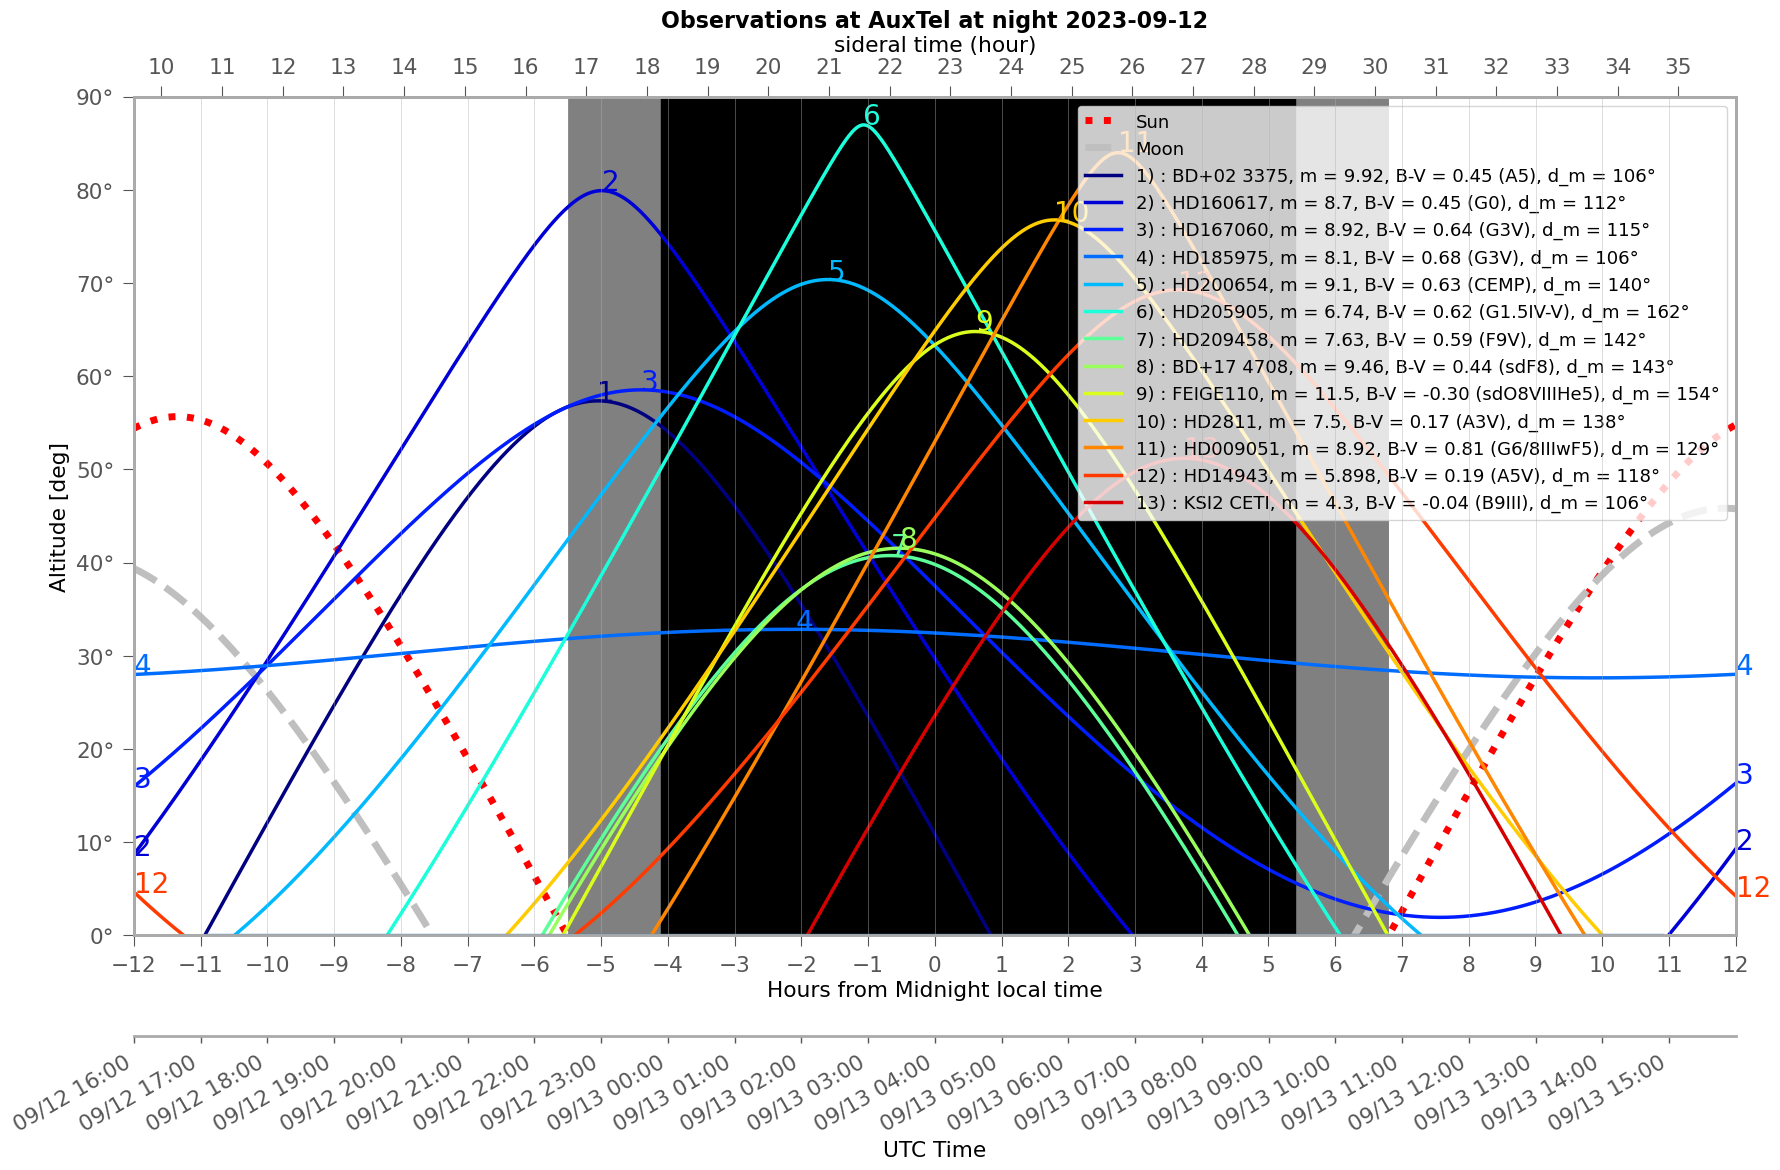

In [88]:
fig = plt.figure(figsize=(18,12))


# First Axis : target sky trajectories
# ====================================
ax=fig.add_subplot(1,1,1)

# plot sun
ax.plot(delta_midnight, sunaltazs_evening_to_morning.alt, color='r', ls=":",label='Sun',lw=5)
#plot moon
ax.plot(delta_midnight, moonaltazs_evening_to_morning.alt, color=[0.75]*3, ls='--', label='Moon',lw=5)


# loop on selected targets in pandas dataframe t according rank order
for index in range(NTargets):
    
    # select the good row in pandas dataframe from time ordering
    row = (t[t["rank_tmax"] == index]).iloc[0]
    

    # get its tag
    label = str(index+1) + ") : " + row["tag"]
    
    # rank in all_target_altazs_evening_to_morning table
    rank_num = row["rank_num"]
    tmax = row["tmax"]
    altmax = row["alt_max"]
    
    
  
    # plot trajectory
    ax.plot(delta_midnight, all_target_altazs_evening_to_morning[rank_num].alt,label=label, lw=2.5,color=all_colors[index])

    # plot label
    if all_target_altazs_evening_to_morning[rank_num].alt[-1]>0:
        ax.text(delta_midnight[-1], all_target_altazs_evening_to_morning[rank_num].alt[-1], f'{index+1}',color=all_colors[index],fontsize=20)
    if all_target_altazs_evening_to_morning[rank_num].alt[0]>0:
        ax.text(delta_midnight[0], all_target_altazs_evening_to_morning[rank_num].alt[0], f'{index+1}',color=all_colors[index],fontsize=20)
    if altmax>0 :
        ax.text(tmax, altmax, f'{index+1}',color=all_colors[index],fontsize=20)
    


ax.fill_between(delta_midnight, 0*u.deg, 90*u.deg,sunaltazs_evening_to_morning.alt < -0*u.deg, color='0.5', zorder=0)
ax.fill_between(delta_midnight, 0*u.deg, 90*u.deg,sunaltazs_evening_to_morning.alt < -18*u.deg, color='k', zorder=0)

ax.legend(loc='upper right')
ax.set_xlim(-12*u.hour, 12*u.hour)
ax.set_xticks((np.arange(13)*2-12)*u.hour)
ax.set_ylim(0*u.deg, 90*u.deg)
ax.set_xlabel('Hours from Midnight local time')
ax.set_ylabel('Altitude [deg]')
ax.grid(None)
tick_spacing = 1
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
title = "Observations at AuxTel at night " + night_obs_str.split(" ")[0]
ax.set_title(title)
#for label in ax.get_xticklabels(which='major'):
#    label.set(rotation=30, horizontalalignment='right')


# second horizontal axis : Sideral time axis
# ==========================================
ax2 = ax.twiny()
ax2.plot([sideral_times[0].hour,sideral_times[-1].hour],[0,0])
ax2.set_xlabel("sideral time (hour)")
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax2.grid(None)

# third horizontal axis : UTC time axis
# =====================================

ax3 = ax.twiny()
# Move twinned axis ticks and label from top to bottom
ax3.xaxis.set_ticks_position("bottom")
ax3.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
offset = -0.12
ax3.spines["bottom"].set_position(("axes", offset))

ax3.set_frame_on(True)
ax3.patch.set_visible(False) # mandatory
for sp in ax3.spines.values():
    sp.set_visible(False)
ax3.spines["bottom"].set_visible(True)
fmt = '%m/%d %H:%M'
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(fmt))
ax3.xaxis.set_major_locator(mdates.HourLocator(interval=1))

curvetoremove, = ax3.plot_date(times_evening_to_morning_datetime, sunaltazs_evening_to_morning.alt, color='r', ls=":",lw=0)
curvetoremove.remove()
ax3.set_xlim(times_evening_to_morning_datetime[0], times_evening_to_morning_datetime[-1])



ax3.tick_params(which='major', width=1.00, length=5)
ax3.tick_params(which='minor', width=0.75, length=2.5)
ax3.grid(True)
#plt.gcf().autofmt_xdate()  # orient date labels at a slant
# slant for this axis
for label in ax3.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax3.set_xlabel("UTC Time")

if FLAG_PRESELECTION_TARGET: 
    figname="AuxtelStarAlt_preselectedcalspec{:4d}_{:d}_{:d}.png".format(NYEAR,NMONTH,NDAY)
else:
    figname="AuxtelStarAlt_visiblecalspec{:4d}_{:d}_{:d}.png".format(NYEAR,NMONTH,NDAY)

plt.tight_layout()
plt.savefig(figname)

plt.show()

# To plot in staralt

https://www.ing.iac.es//Astronomy/telescopes/wht/catformat.html

In [89]:
t_staralt = t[["Star_name","RA","Decl","rank_tmax"]]
t_staralt["equinox"] = np.full(NTargets,"J2000")
t_staralt = t_staralt.sort_values(by = ['rank_tmax'])
t_staralt = t_staralt.drop(['rank_tmax'], axis=1)

/var/folders/cq/vms8st5136z3q5xx4rd9xqfr0000gw/T/ipykernel_20193/2260111632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_staralt["equinox"] = np.full(NTargets,"J2000")


In [90]:
t_staralt

,Star_name,RA,Decl,equinox
0,BD+02 3375,17 39 45.595,+02 24 59.61,J2000
5,HD160617,17 42 49.324,-40 19 15.51,J2000
6,HD167060,18 17 44.143,-61 42 31.62,J2000
7,HD185975,20 28 18.740,-87 28 19.94,J2000
8,HD200654,21 06 34.751,-49 57 50.28,J2000
9,HD205905,21 39 10.151,-27 18 23.67,J2000
10,HD209458,22 03 10.773,+18 53 03.55,J2000
1,BD+17 4708,22 11 31.375,+18 05 34.16,J2000
2,FEIGE110,23 19 58.400,-05 09 56.17,J2000
11,HD2811,00 31 18.490,-43 36 23.00,J2000


In [91]:
t_staralt.to_csv("staralt.csv",index=False,header=False, sep = " ")

In [92]:
! cat staralt.csv

"BD+02 3375" "17 39 45.595" "+02 24 59.61" J2000
HD160617 "17 42 49.324" "-40 19 15.51" J2000
HD167060 "18 17 44.143" "-61 42 31.62" J2000
HD185975 "20 28 18.740" "-87 28 19.94" J2000
HD200654 "21 06 34.751" "-49 57 50.28" J2000
HD205905 "21 39 10.151" "-27 18 23.67" J2000
HD209458 "22 03 10.773" "+18 53 03.55" J2000
"BD+17 4708" "22 11 31.375" "+18 05 34.16" J2000
FEIGE110 "23 19 58.400" "-05 09 56.17" J2000
HD2811 "00 31 18.490" "-43 36 23.00" J2000
HD009051 "01 28 46.503" "-24 20 25.44" J2000
HD14943 "02 22 54.675" "-51 05 31.66" J2000
"KSI2 CETI" "02 28 09.557" "+08 27 36.22" J2000


# Spheric plot

In [93]:
def makePolarPlot(azimuthsInDegrees, zenithAngles, marker=".",ax=None,
                       title=None, color=None, objName=None,lw=0.5):
    if ax==None:
        _ = plt.figure(figsize=(20, 10))
        ax = plt.subplot(111, polar=True)
        
    ax.plot([a*np.pi/180 for a in azimuthsInDegrees], zenithAngles, marker, c=color, label=objName,lw=lw)
    if title:
        ax.set_title(title, va='bottom')
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_rlim(0, 90)
    return ax

In [94]:
darkTimeIndex=[sunaltazs_evening_to_morning.alt < -18*u.deg]

/var/folders/cq/vms8st5136z3q5xx4rd9xqfr0000gw/T/ipykernel_20193/1699125589.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moon_azimuthsInDegreesNight=moon_azimuthsInDegrees[darkTimeIndex]
/var/folders/cq/vms8st5136z3q5xx4rd9xqfr0000gw/T/ipykernel_20193/1699125589.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  moon_zenithAnglesNight=moon_zenithAngles[darkTimeIndex]
/var/folders/cq/vms8st5136z3q5xx4rd9xqfr0000gw/T/ipykernel_20193/1699125589.py:44: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprec

Text(0.5, 1.0, 'Observations at AuxTel at night 2023-09-12')

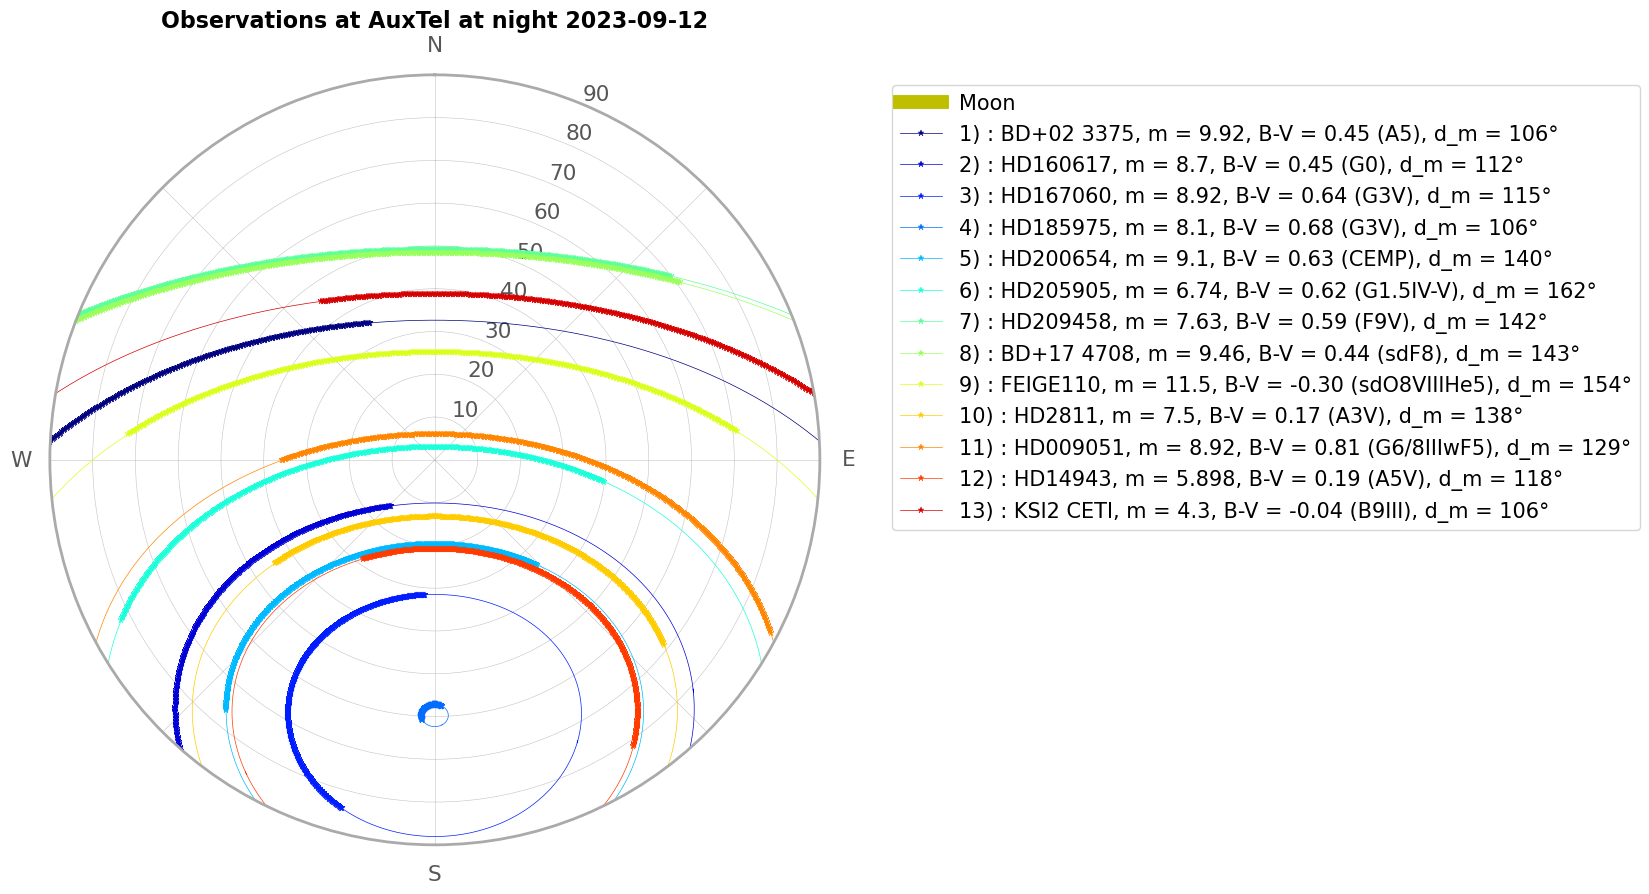

In [95]:
_ = plt.figure(figsize=(20, 10))

ax = plt.subplot(111, polar=True)


darkTimeIndex=[sunaltazs_evening_to_morning.alt < -18*u.deg]

# compute zenith and azimuth angles
moon_azimuthsInDegrees = Angle(moonaltazs_evening_to_morning.az).deg
moon_zenithAngles = Angle(moonaltazs_evening_to_morning.zen).deg

#ax=makePolarPlot(moon_azimuthsInDegrees, moon_zenithAngles,ax=ax, marker="--",color="y", title = None, lw=1)

moon_azimuthsInDegreesNight=moon_azimuthsInDegrees[darkTimeIndex]
moon_zenithAnglesNight=moon_zenithAngles[darkTimeIndex]
ax=makePolarPlot(moon_azimuthsInDegreesNight, moon_zenithAnglesNight,ax=ax ,marker="*-",title=None, color = "y",objName="Moon",lw=10)

    
# loop on selected targets in pandas dataframe t according rank order
for index in range(NTargets):
    
    # select the good row in pandas dataframe from time ordering
    row = (t[t["rank_tmax"] == index]).iloc[0]
    

    # get its tag
    label = str(index+1) + ") : " + row["tag"]
    
    # rank in all_target_altazs_evening_to_morning table
    rank_num = row["rank_num"]
    tmax = row["tmax"]
    altmax = row["alt_max"]
    
    
    
    
    
    # compute zenith and azimuth angles
    azimuthsInDegrees=Angle(all_target_altazs_evening_to_morning[rank_num].az).deg
    zenithAngles = Angle(all_target_altazs_evening_to_morning[rank_num].zen).deg
    
    ax=makePolarPlot(azimuthsInDegrees, zenithAngles,ax=ax, marker="-",title=None, color=all_colors[index], lw=0.5)
    
    azimuthsInDegreesNight=azimuthsInDegrees[darkTimeIndex]
    zenithAnglesNight=zenithAngles[darkTimeIndex]
    ax=makePolarPlot(azimuthsInDegreesNight, zenithAnglesNight,ax=ax ,marker="*-",title=None, color=all_colors[index],objName=label,lw=0.5)
    
    thex=zenithAnglesNight[0]*np.sin( (azimuthsInDegreesNight[0]) *np.pi/180.)
    they=zenithAnglesNight[0]*np.cos( (azimuthsInDegreesNight[0])*np.pi/180.)
   
    #plt.text(thex, they,f'{rank}',color=all_colors[rank],fontsize=20)
    
 
ax.legend(bbox_to_anchor=(1.08, 1), prop={'size': 15}, loc='upper left')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlim(0, 90)
ax.set_xticklabels(['N', '', 'E', '', 'S', '', 'W', ''])
title = "Observations at AuxTel at night " + night_obs_str.split(" ")[0]
ax.set_title(title)

# Spectra

In [96]:
from getCalspec.getCalspec import *

In [97]:
plt.rcParams["figure.figsize"]=(8,4)

In [98]:
NTargets

13

In [99]:
ncols = 2

if NTargets % ncols == 0:
    nrows = NTargets//ncols+1
else:
    nrows = int(np.floor(NTargets/ncols))+1

In [100]:
nrows

7

In [101]:
XMIN = 300.
XMAX = 1100.

/var/folders/cq/vms8st5136z3q5xx4rd9xqfr0000gw/T/ipykernel_20193/975576899.py:58: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


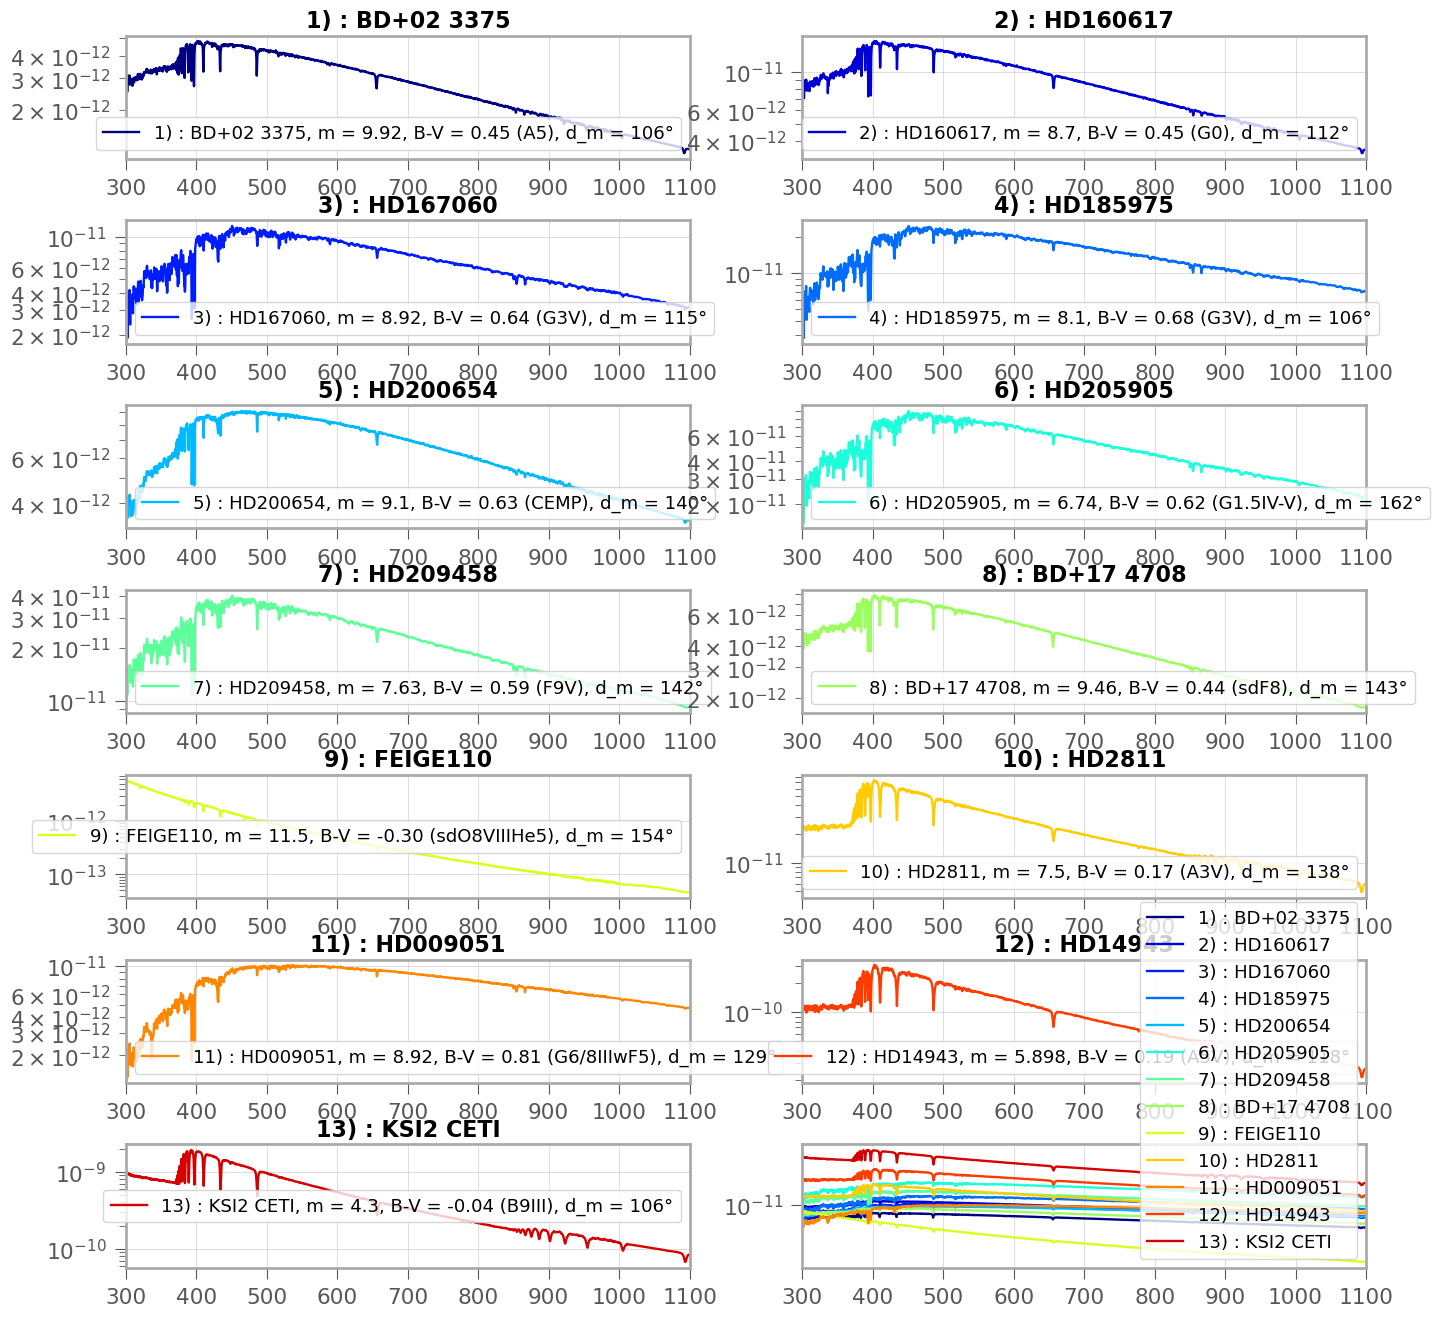

In [102]:
fig, axes= plt.subplots(nrows=nrows,ncols=ncols,sharex=False,figsize=(16,16))

# loop on selected targets in pandas dataframe t according rank order
all_wl = []
all_fl = []
all_obj= []

for index, ax in enumerate(axes.flat):
    
    if index < NTargets:
    
        # select the good row in pandas dataframe from time ordering
        row = (t[t["rank_tmax"] == index]).iloc[0]
    

        # get its tag
        label = str(index+1) + ") : " + row["tag"]
    
        # rank in all_target_altazs_evening_to_morning table
        target_name = row["Star_name"]
    
        test = is_calspec(target_name)
    
        if test:
        
            c = Calspec(target_name)
            c.get_spectrum_fits_filename()  # download the fits file
            tab = c.get_spectrum_table()  # download and return an Astropy table
            arr = c.get_spectrum_numpy()  # download and return a dictionnary of numpy arrays with units
            #c.plot_spectrum()  # download and plot the spectrum
            
            wl = arr['WAVELENGTH'].to_value()/10.
            fl = arr['FLUX'].to_value()*10.
            
            indexes = np.where(np.logical_and(wl>=XMIN,wl<=XMAX))[0]
            
            wl = wl[indexes]
            fl = fl[indexes]
            ax.plot(wl,fl,"-",color=all_colors[index],label=label)
            ax.set_yscale("log")
            title = f"{index+1}) : {target_name}"
            ax.set_title(title)
            ax.legend()
            ax.set_xlim(XMIN,XMAX)
            
            all_wl.append(wl)
            all_fl.append(fl)
            all_obj.append(title)
        else:
            print(f"{target_name} NOT A CALSPEC")
    else:
        if index == NTargets:
            for j in range(NTargets):
                ax.plot(all_wl[j], all_fl[j],'-',color=all_colors[j],label=all_obj[j] )
            ax.set_yscale("log")
            ax.legend()
            ax.set_xlim(XMIN,XMAX)
plt.tight_layout()            

Text(0, 0.5, 'FLAM')

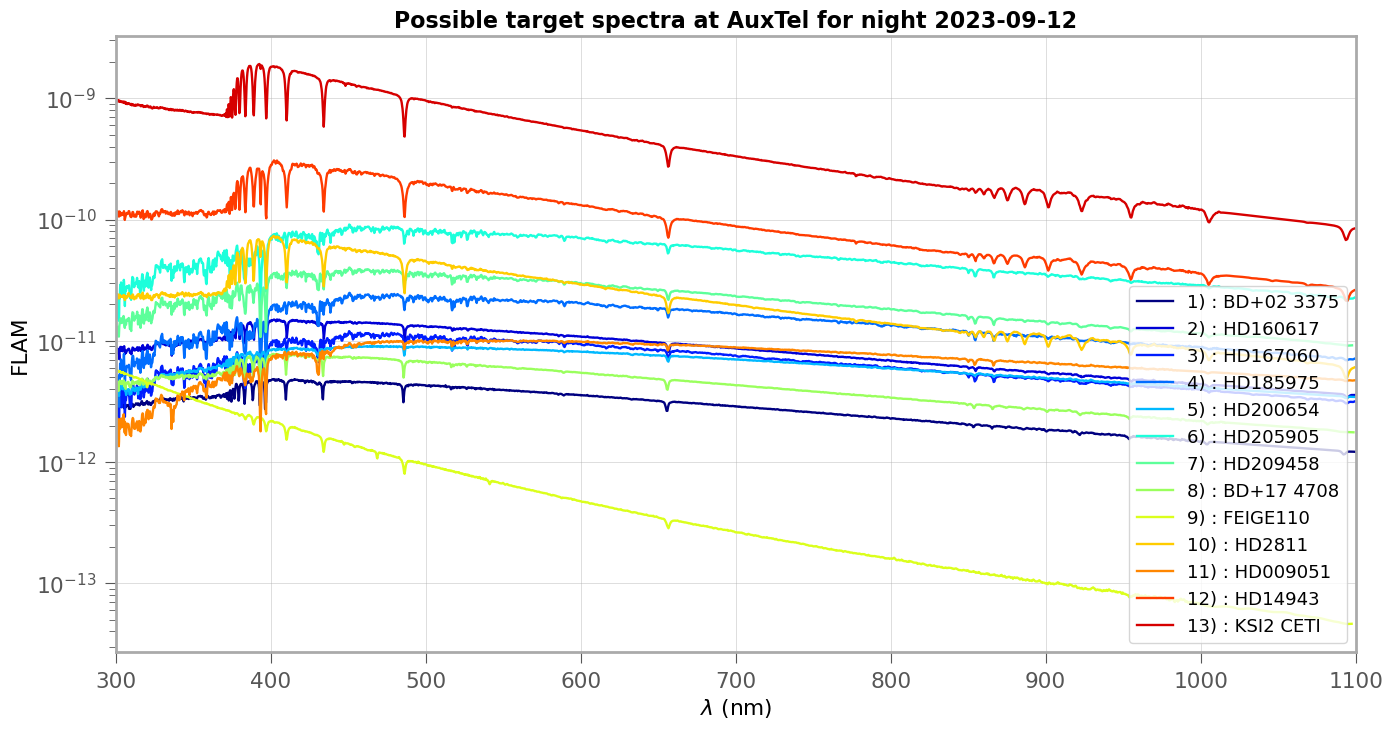

In [103]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8))

for j in range(NTargets):
    ax.plot(all_wl[j], all_fl[j],'-',color=all_colors[j],label=all_obj[j] )
    ax.set_yscale("log")
    ax.legend()
    ax.set_xlim(XMIN,XMAX)
title = "Possible target spectra at AuxTel for night " + night_obs_str.split(" ")[0]
ax.set_title(title) 
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("FLAM")

## Choose spectra

In [104]:
index_chosen_spectra = np.array([2,6, 4]) -1

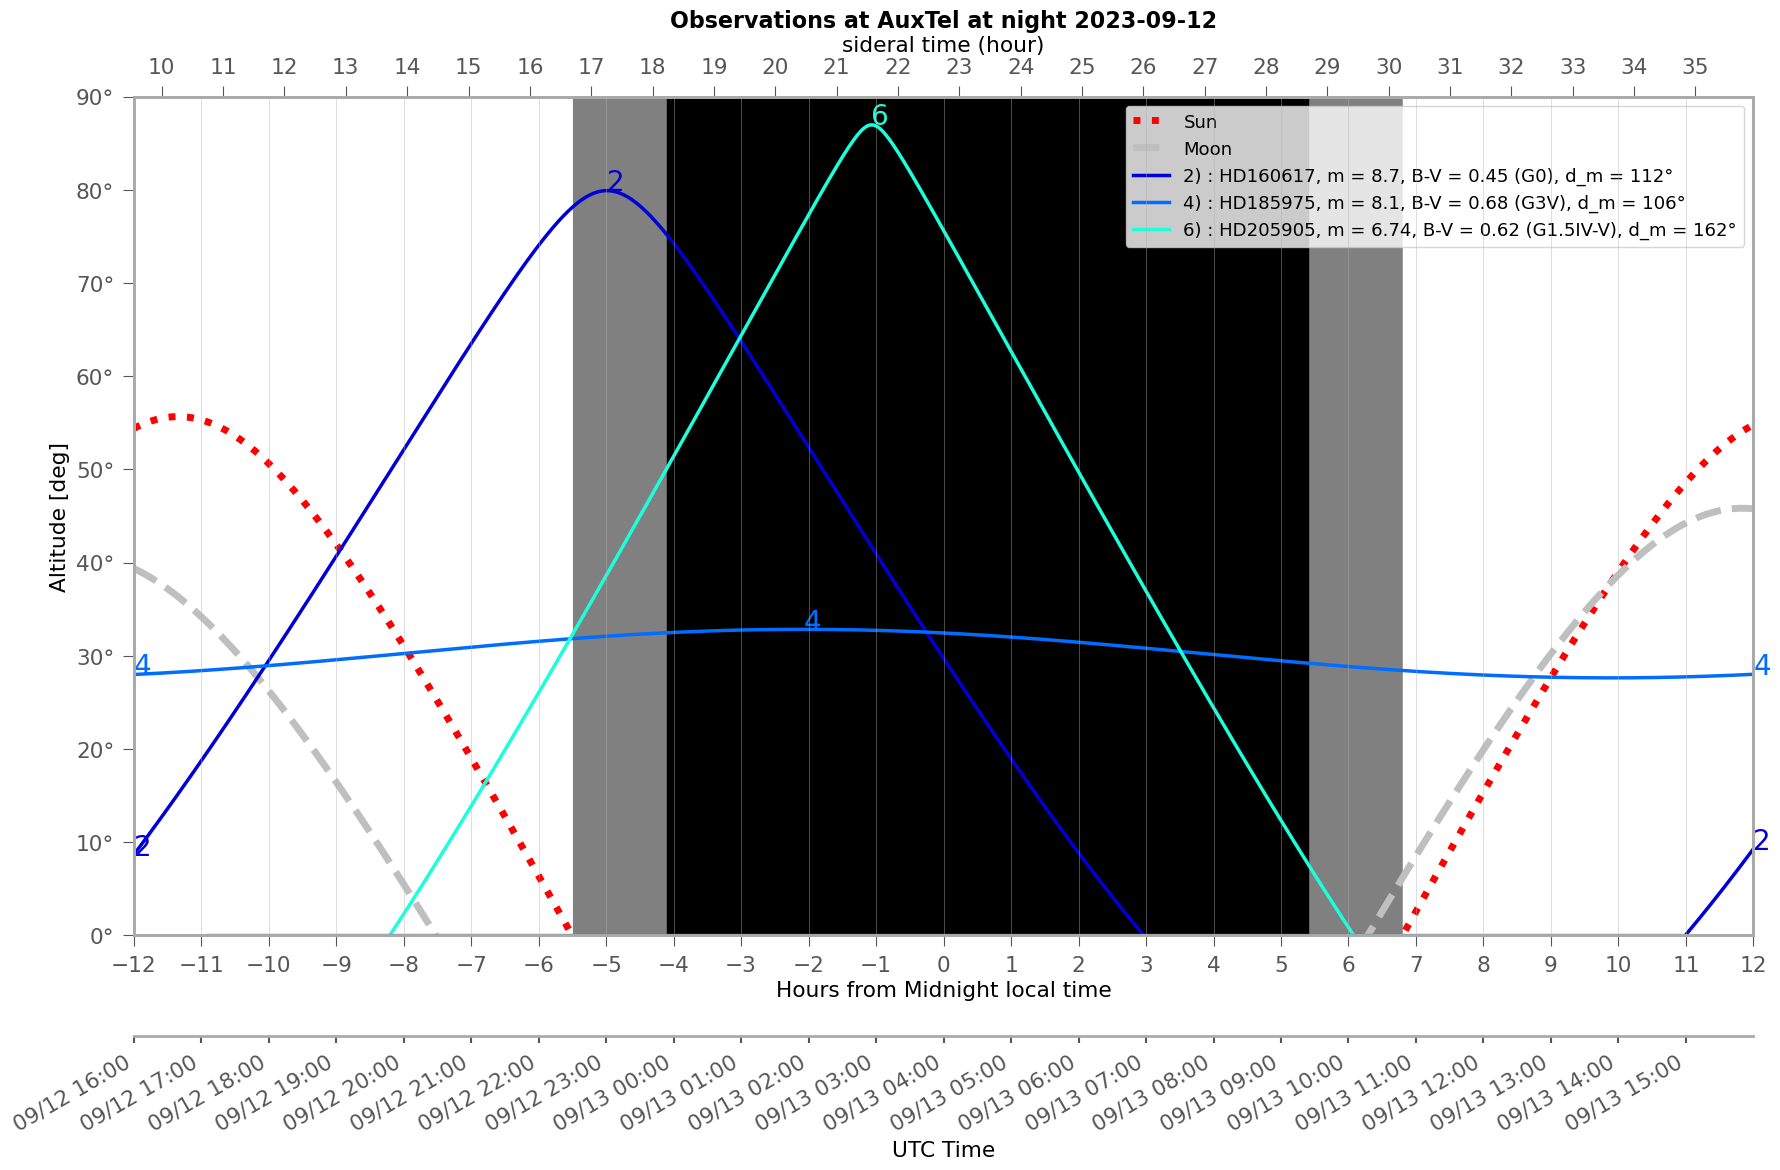

In [105]:
fig = plt.figure(figsize=(18,12))
ax=fig.add_subplot(1,1,1)


# First Axis : target sky trajectories
# ====================================

# plot sun
ax.plot(delta_midnight, sunaltazs_evening_to_morning.alt, color='r', ls=":",label='Sun',lw=5)
#plot moon
ax.plot(delta_midnight, moonaltazs_evening_to_morning.alt, color=[0.75]*3, ls='--', label='Moon',lw=5)


# loop on selected targets in pandas dataframe t according rank order
for index in range(NTargets):
    
    if index not in index_chosen_spectra:
        continue
    
    # select the good row in pandas dataframe from time ordering
    row = (t[t["rank_tmax"] == index]).iloc[0]
    

    # get its tag
    label = str(index+1) + ") : " + row["tag"]
    
    # rank in all_target_altazs_evening_to_morning table
    rank_num = row["rank_num"]
    tmax = row["tmax"]
    altmax = row["alt_max"]
    
    
  
    # plot trajectory
    ax.plot(delta_midnight, all_target_altazs_evening_to_morning[rank_num].alt,label=label, lw=2.5,color=all_colors[index])

    # plot label
    if all_target_altazs_evening_to_morning[rank_num].alt[-1]>0:
        ax.text(delta_midnight[-1], all_target_altazs_evening_to_morning[rank_num].alt[-1], f'{index+1}',color=all_colors[index],fontsize=20)
    if all_target_altazs_evening_to_morning[rank_num].alt[0]>0:
        ax.text(delta_midnight[0], all_target_altazs_evening_to_morning[rank_num].alt[0], f'{index+1}',color=all_colors[index],fontsize=20)
    if altmax>0 :
        ax.text(tmax, altmax, f'{index+1}',color=all_colors[index],fontsize=20)
    


ax.fill_between(delta_midnight, 0*u.deg, 90*u.deg,sunaltazs_evening_to_morning.alt < -0*u.deg, color='0.5', zorder=0)
ax.fill_between(delta_midnight, 0*u.deg, 90*u.deg,sunaltazs_evening_to_morning.alt < -18*u.deg, color='k', zorder=0)

ax.legend(loc='upper right')
ax.set_xlim(-12*u.hour, 12*u.hour)
ax.set_xticks((np.arange(13)*2-12)*u.hour)
ax.set_ylim(0*u.deg, 90*u.deg)
ax.set_xlabel('Hours from Midnight local time')
ax.set_ylabel('Altitude [deg]')
ax.grid(None)
tick_spacing = 1
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
title = "Observations at AuxTel at night " + night_obs_str.split(" ")[0]
ax.set_title(title)


#Second axis : Sideral time axis
# ==============================

ax2 = ax.twiny()
ax2.plot([sideral_times[0].hour,sideral_times[-1].hour],[0,0])
ax2.set_xlabel("sideral time (hour)")
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax2.grid(None)


# Third horizontal axis : UTC time
# ================================

ax3 = ax.twiny()
# Move twinned axis ticks and label from top to bottom
ax3.xaxis.set_ticks_position("bottom")
ax3.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
offset = -0.12
ax3.spines["bottom"].set_position(("axes", offset))

ax3.set_frame_on(True)
ax3.patch.set_visible(False) # mandatory
for sp in ax3.spines.values():
    sp.set_visible(False)
ax3.spines["bottom"].set_visible(True)
fmt = '%m/%d %H:%M'
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(fmt))
ax3.xaxis.set_major_locator(mdates.HourLocator(interval=1))

curvetoremove, = ax3.plot_date(times_evening_to_morning_datetime, sunaltazs_evening_to_morning.alt, color='r', ls=":",lw=0)
curvetoremove.remove()
ax3.set_xlim(times_evening_to_morning_datetime[0], times_evening_to_morning_datetime[-1])

ax3.tick_params(which='major', width=1.50, length=5)
ax3.tick_params(which='minor', width=0.75, length=2.5)
ax3.grid(True)
# rotation of labels
for label in ax3.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax3.set_xlabel("UTC Time")

plt.tight_layout()

figname="AuxtelStarAlt_CalspecSpectraSelected{:4d}_{:d}_{:d}.png".format(NYEAR,NMONTH,NDAY)

plt.savefig(figname)
plt.show()